C:\Users\swara\AppData\Local\Temp\ipykernel_8044\2121029979.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  5 of 5 completed



Monte Carlo VaR & CVaR (Correlated Assets):
Confidence Level    VaR (₹)   CVaR (₹)
             90% ₹16,469.60 ₹22,777.63
             95% ₹21,491.14 ₹26,852.26
             99% ₹29,797.05 ₹34,581.62

Backtest of Simulated VaR against Historical P&L:
 CL Sim_VaR (₹)  Historical Breaches  Days Breach Rate
90%  ₹16,469.60                   99  1238       8.00%
95%  ₹21,491.14                   63  1238       5.09%
99%  ₹29,797.05                   25  1238       2.02%


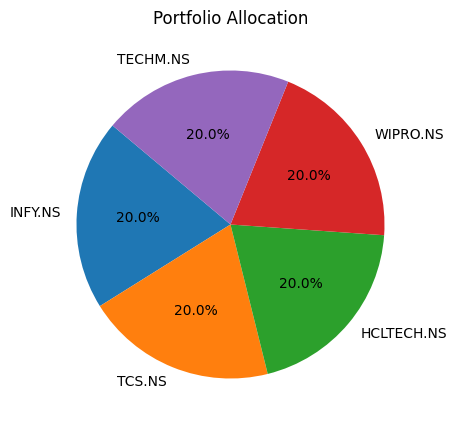

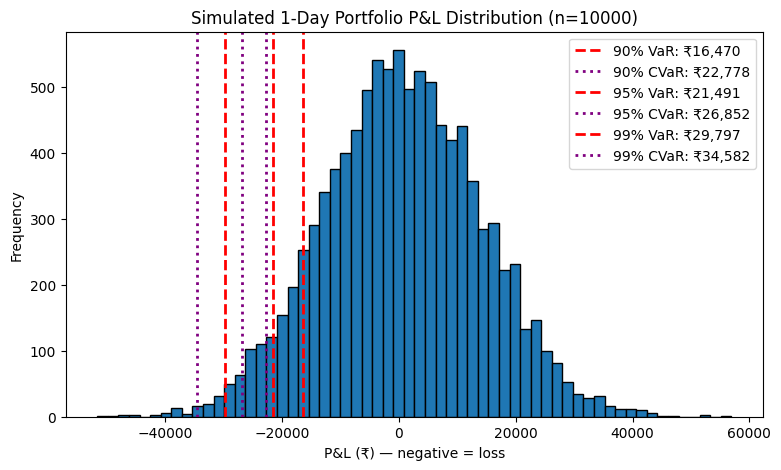

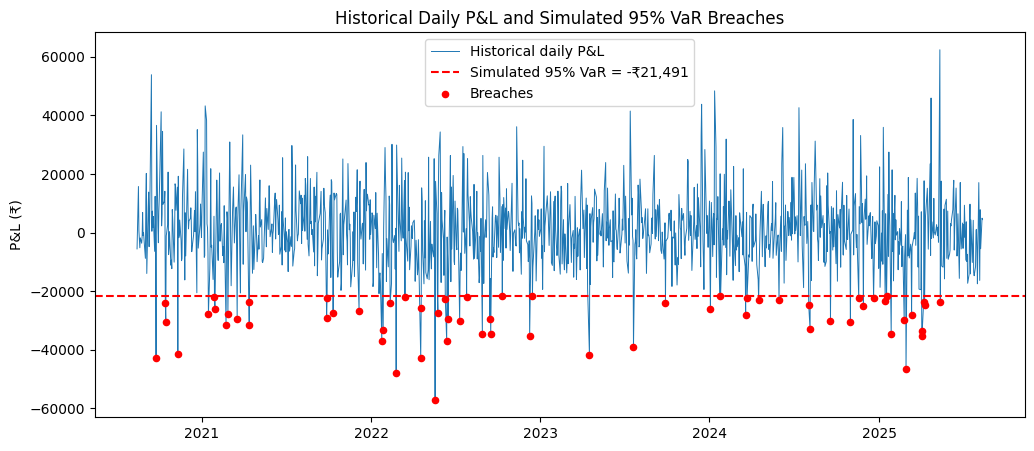

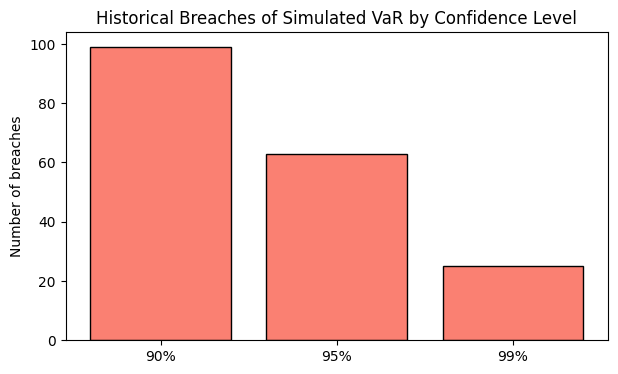

In [1]:
# ==========================
# Monte Carlo VaR with Correlated Asset Returns
# ==========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

# --------------------------
# CONFIG
# --------------------------
YEARS = 5
TICKERS = ['INFY.NS', 'TCS.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS']
WEIGHTS = None  # None for equal weighting, or list/array summing to 1
PORTFOLIO_VALUE = 1_000_000
DAYS = 1
SIMULATIONS = 10000
CONFIDENCE_LEVELS = [0.90, 0.95, 0.99]
SEED = 42
PLOT_RESULTS = True
# --------------------------


# ========== FUNCTIONS ==========
def fetch_prices(tickers, years):
    """Fetch historical adjusted close prices for given tickers."""
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=365 * years)
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']
    return prices.ffill().dropna()


def prepare_weights(weights, n_assets):
    """Normalize portfolio weights."""
    if weights is None:
        weights = np.ones(n_assets) / n_assets
    else:
        weights = np.array(weights, dtype=float)
        if weights.size != n_assets:
            raise ValueError("Number of weights must equal number of tickers.")
        weights /= weights.sum()
    return weights


def simulate_mc_var(mu_vec, cov_matrix, weights, days, sims, portfolio_value, confidence_levels):
    """Run Monte Carlo VaR and CVaR simulation for correlated assets."""
    simulated_asset_returns = np.random.multivariate_normal(
        mean=mu_vec * days,
        cov=cov_matrix * days,
        size=sims
    )
    sim_portfolio_returns = simulated_asset_returns.dot(weights)
    sim_portfolio_pnl = sim_portfolio_returns * portfolio_value

    VaR_results, CVaR_results = {}, {}
    for cl in confidence_levels:
        var_amt = -np.percentile(sim_portfolio_pnl, (1 - cl) * 100)
        tail_losses = sim_portfolio_pnl[sim_portfolio_pnl <= -var_amt]
        cvar_amt = -tail_losses.mean() if tail_losses.size > 0 else var_amt
        VaR_results[cl] = var_amt
        CVaR_results[cl] = cvar_amt

    return sim_portfolio_pnl, VaR_results, CVaR_results


def backtest_var(returns_df, weights, portfolio_value, VaR_results, confidence_levels):
    """Backtest simulated VaR against historical portfolio P&L."""
    hist_portfolio_returns = returns_df.dot(weights)
    hist_portfolio_pnl = hist_portfolio_returns * portfolio_value
    backtest_rows = []

    for cl in confidence_levels:
        var_thr = VaR_results[cl]
        breaches_mask = hist_portfolio_pnl < -var_thr
        breaches = breaches_mask.sum()
        total_days = len(hist_portfolio_pnl)
        backtest_rows.append({
            "CL": f"{int(cl*100)}%",
            "Sim_VaR (₹)": f"₹{var_thr:,.2f}",
            "Historical Breaches": breaches,
            "Days": total_days,
            "Breach Rate": f"{breaches/total_days:.2%}"
        })
    return pd.DataFrame(backtest_rows), hist_portfolio_pnl


def plot_results(weights, tickers, sim_pnl, VaR_results, CVaR_results,
                 hist_pnl, backtest_df, confidence_levels, days, sims):
    """Plot portfolio allocation, P&L distributions, and breach analysis."""
    # 1) Portfolio allocation
    plt.figure(figsize=(5, 5))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140)
    plt.title("Portfolio Allocation")
    plt.show()

    # 2) Simulated P&L histogram
    plt.figure(figsize=(9, 5))
    plt.hist(sim_pnl, bins=60, edgecolor='black')
    for cl in confidence_levels:
        plt.axvline(-VaR_results[cl], color='red', linestyle='--', linewidth=2,
                    label=f"{int(cl*100)}% VaR: ₹{VaR_results[cl]:,.0f}")
        plt.axvline(-CVaR_results[cl], color='purple', linestyle=':', linewidth=2,
                    label=f"{int(cl*100)}% CVaR: ₹{CVaR_results[cl]:,.0f}")
    plt.title(f"Simulated {days}-Day Portfolio P&L Distribution (n={sims})")
    plt.xlabel("P&L (₹) — negative = loss")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # 3) Historical P&L with breaches (example: 95% CL)
    cl_plot = 0.95
    var_thr_plot = VaR_results[cl_plot]
    breaches_mask = hist_pnl < -var_thr_plot
    plt.figure(figsize=(12, 5))
    plt.plot(hist_pnl.index, hist_pnl, label="Historical daily P&L", linewidth=0.7)
    plt.axhline(-var_thr_plot, color='red', linestyle='--',
                label=f"Simulated {int(cl_plot*100)}% VaR = -₹{var_thr_plot:,.0f}")
    plt.scatter(hist_pnl.index[breaches_mask], hist_pnl[breaches_mask],
                color='red', s=20, zorder=5, label="Breaches")
    plt.title(f"Historical Daily P&L and Simulated {int(cl_plot*100)}% VaR Breaches")
    plt.ylabel("P&L (₹)")
    plt.legend()
    plt.show()

    # 4) Breach counts bar chart
    plt.figure(figsize=(7, 4))
    plt.bar(backtest_df["CL"], backtest_df["Historical Breaches"],
            color='salmon', edgecolor='black')
    plt.title("Historical Breaches of Simulated VaR by Confidence Level")
    plt.ylabel("Number of breaches")
    plt.show()


# ========== MAIN SCRIPT ==========
def main():
    np.random.seed(SEED)

    # Step 1: Data fetching
    prices = fetch_prices(TICKERS, YEARS)
    returns_df = prices.pct_change().dropna()

    # Step 2: Prepare inputs
    mu_vec = returns_df.mean().values
    cov_matrix = returns_df.cov().values
    weights = prepare_weights(WEIGHTS, len(TICKERS))

    # Step 3: Monte Carlo simulation
    sim_pnl, VaR_results, CVaR_results = simulate_mc_var(
        mu_vec, cov_matrix, weights, DAYS, SIMULATIONS,
        PORTFOLIO_VALUE, CONFIDENCE_LEVELS
    )

    # Step 4: Results table
    results_table = pd.DataFrame({
        "Confidence Level": [f"{int(cl*100)}%" for cl in CONFIDENCE_LEVELS],
        "VaR (₹)": [f"₹{VaR_results[cl]:,.2f}" for cl in CONFIDENCE_LEVELS],
        "CVaR (₹)": [f"₹{CVaR_results[cl]:,.2f}" for cl in CONFIDENCE_LEVELS]
    })
    print("\nMonte Carlo VaR & CVaR (Correlated Assets):")
    print(results_table.to_string(index=False))

    # Step 5: Backtesting
    backtest_df, hist_pnl = backtest_var(
        returns_df, weights, PORTFOLIO_VALUE, VaR_results, CONFIDENCE_LEVELS
    )
    print("\nBacktest of Simulated VaR against Historical P&L:")
    print(backtest_df.to_string(index=False))

    # Step 6: Plots
    if PLOT_RESULTS:
        plot_results(weights, TICKERS, sim_pnl, VaR_results, CVaR_results,
                     hist_pnl, backtest_df, CONFIDENCE_LEVELS, DAYS, SIMULATIONS)


if __name__ == "__main__":
    main()
# ==========================